<a href="https://colab.research.google.com/github/amr-elbana/EcoSortAI-Classifier/blob/main/notebooks/Original_waste_efficientnetB2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import keras,os
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Input, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.efficientnet import preprocess_input, EfficientNetB2

In [14]:
# Define paths and constants
data_dir = "/content/drive/MyDrive/DL_Project/RealWaste"
test_dir = "/content/drive/MyDrive/DL_Project/RealWaste-test"
batch_size = 32
target_size = (224, 224)
epochs = 100

In [15]:
# import os
# import shutil
# from sklearn.model_selection import train_test_split

# # Specify dataset paths
# dataset_path = "/path/to/dataset"
# output_dir = "/path/to/output"

# # Create output folders for train, validation, and test splits
# for split in ["train", "val", "test"]:
#     for class_name in os.listdir(dataset_path):
#         os.makedirs(os.path.join(output_dir, split, class_name), exist_ok=True)

# # Function to split and move files
# def split_dataset(dataset_path, output_dir, test_size=0.2, val_size=0.2):
#     for class_name in os.listdir(dataset_path):
#         class_path = os.path.join(dataset_path, class_name)
#         if not os.path.isdir(class_path):
#             continue

#         # Get all file paths for the class
#         files = [os.path.join(class_path, file) for file in os.listdir(class_path)]

#         # Split into train, temp (validation + test)
#         train_files, temp_files = train_test_split(files, test_size=(test_size + val_size), random_state=42)

#         # Split temp into validation and test
#         val_files, test_files = train_test_split(temp_files, test_size=(test_size / (test_size + val_size)), random_state=42)

#         # Move files to respective directories
#         for file in train_files:
#             shutil.move(file, os.path.join(output_dir, "train", class_name))
#         for file in val_files:
#             shutil.move(file, os.path.join(output_dir, "val", class_name))
#         for file in test_files:
#             shutil.move(file, os.path.join(output_dir, "test", class_name))

# # Call the function
# split_dataset(dataset_path, output_dir)


In [16]:
# Create an ImageDataGenerator with EfficientNetB2 preprocessing and data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # EfficientNetB2-specific preprocessing
    validation_split=0.2,  # Use 20% of data for validation
)

# Flow training data from the directory and apply preprocessing and augmentation
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=target_size,      # Resize images to EfficientNetB2 input size
    batch_size=batch_size,
    class_mode='binary',          # Binary classification (healthy vs rotten)
    subset='training',            # Use 80% of data for training
    seed=42,                      # Set seed for reproducibility
    shuffle=True                  # Shuffle the data to improve training
)

# Flow validation data from the directory and apply preprocessing (no augmentation for validation)
validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=target_size,      # Resize images to EfficientNetB2 input size
    batch_size=batch_size,
    class_mode='binary',          # Binary classification (healthy vs rotten)
    subset='validation',          # Use 20% of data for validation
    shuffle=False                 # No need to shuffle validation data
)

# ... (rest of the code remains the same)

# Check the number of samples in each generator
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Training batches per epoch: {len(train_generator)}")
print(f"Validation batches per epoch: {len(validation_generator)}")

Found 3043 images belonging to 2 classes.
Found 759 images belonging to 2 classes.
Training samples: 3043
Validation samples: 759
Training batches per epoch: 96
Validation batches per epoch: 24


In [17]:
# Create an ImageDataGenerator for EfficientNetB2 preprocessing (no augmentation for the test set)
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input  # EfficientNetB2-specific preprocessing
)

# Flow data from the test directory and apply preprocessing
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # efficientnetB2 input size
    batch_size=batch_size,
    class_mode='binary',     # Binary classification for the test set
    shuffle=False            # Do not shuffle test data to keep results consistent
)

# Check the number of samples in the test set
print(f"Test samples: {test_generator.samples}")
print(f"Test batches: {len(test_generator)}")

Found 950 images belonging to 2 classes.
Test samples: 950
Test batches: 30


In [18]:
import os
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
def create_model():
    # Load EfficientNetB2 model with pretrained weights, excluding the top (fully connected) layers
    efficientnet_base = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the layers of EfficientNetB2 to retain the pre-trained weights
    efficientnet_base.trainable = False
    # Build the model
    model = Sequential([
        efficientnet_base,  # Add the entire base model
        GlobalAveragePooling2D(),  # Use global pooling instead of Flatten, This is more efficient and typically used for pre-trained convolutional models.
        Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # For binary classification
    ])

    # Compile the model
    optimizer = SGD(learning_rate=0.0001, momentum=0.9)  # Lower learning rate
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

    return model

# Define the model
model = create_model()
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb2 (Functional)          │ (None, 7, 7, 1408)          │       7,768,569 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1408)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         360,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,195,322 (31.26 MB)

 Trainable params: 426,753 (1.63 MB)

 Non-trainable params: 7,768,569 (29.63 MB)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# Define callbacks
checkpoint_path = "/content/drive/MyDrive/DL_Project/Original_Models2/Waste_Original_EfficientNetB2_{epoch:02d}-{val_accuracy:0.2f}.keras"

# ModelCheckpoint: Save best model based on val_accuracy
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  # Save the best model based on validation accuracy
    verbose=1,
    save_best_only=True,
    mode='max'
)

early_stopping_monitor = EarlyStopping(
    monitor='val_loss',         # Focus on reducing overfitting
    patience=5,                # Allow enough time for gradual improvements
    restore_best_weights=True,  # Load the best weights after stopping
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Adjust learning rate if validation loss doesn't improve
    factor=0.2,          # Reduce learning rate by a factor of 5
    patience=2,          # Wait 5 epochs before reducing
    min_lr=1e-6,         # Set a minimum learning rate
    verbose=1
)
# Train the model
History = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    callbacks=[checkpoint, early_stopping_monitor, reduce_lr]
)
model.save('/content/drive/MyDrive/DL_Project/Original_Models2/Original_EfficientNetB2_best_model.h5')

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5168 - loss: 1.4128
Epoch 1: val_accuracy improved from -inf to 0.69038, saving model to /content/drive/MyDrive/DL_Project/Original_Models2/Waste_Original_EfficientNetB2_01-0.69.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 1075s 10s/step - accuracy: 0.5171 - loss: 1.4127 - val_accuracy: 0.6904 - val_loss: 1.3181 - learning_rate: 1.0000e-04
Epoch 2/30
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.6074 - loss: 1.3494
Epoch 2: val_accuracy improved from 0.69038 to 0.69829, saving model to /content/drive/MyDrive/DL_Project/Original_Models2/Waste_Original_EfficientNetB2_02-0.70.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 34s 333ms/step - accuracy: 0.6078 - loss: 1.3492 - val_accuracy: 0.6983 - val_loss: 1.2910 - learning_rate: 1.0000e-04
Epoch 3/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.6580 - loss: 1.3157
Epoch 3: val_accuracy did not improve from 0.69829
96/96 ━━━━━━━━━━━━━━━━━━━━ 38s 306ms/step - accuracy: 0.6580 - loss: 1.3157 - val_

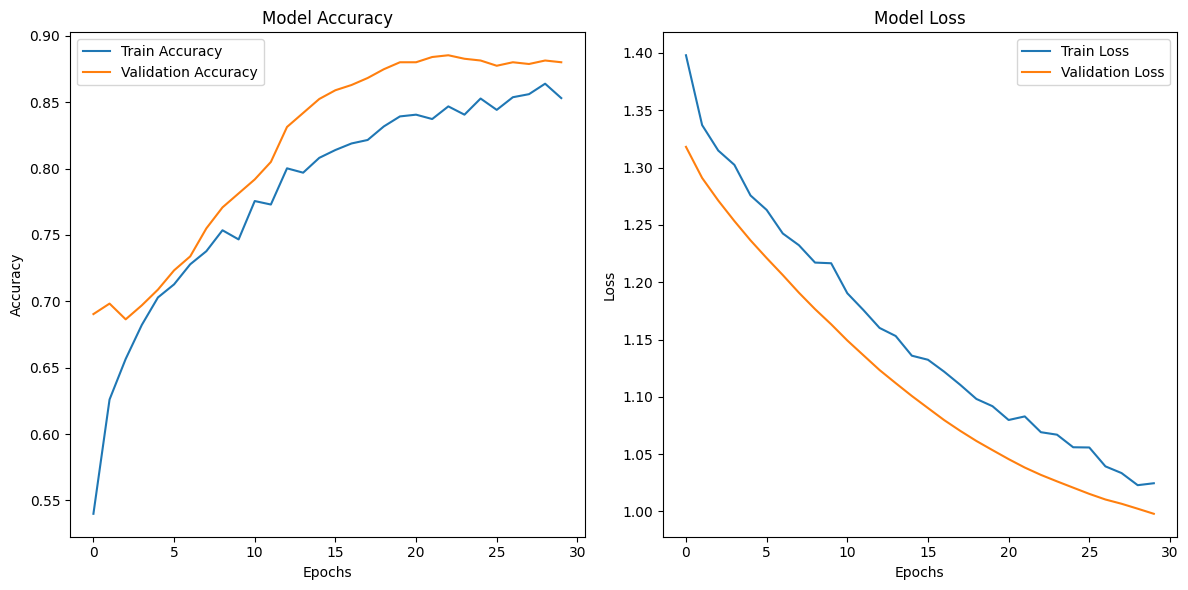

In [20]:
import matplotlib.pyplot as plt

# Extract the training history
history = History.history

# Plot training & validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
final_train_acc = History.history['accuracy'][-1]
final_val_acc = History.history['val_accuracy'][-1]
final_train_loss = History.history['loss'][-1]
final_val_loss = History.history['val_loss'][-1]

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")


Final Training Accuracy: 0.8531
Final Validation Accuracy: 0.8801
Final Training Loss: 1.0246
Final Validation Loss: 0.9980


In [22]:
if 'lr' in History.history:
    plt.plot(History.history['lr'], label='Learning Rate')
    plt.title('Learning Rate Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.show()

In [23]:
import json

# Save history to a JSON file on Google Drive
with open("/content/drive/MyDrive/DL_Project/Original_Models2/training_history.json", "w") as f:
    json.dump(History.history, f)

# Load the history later
with open("/content/drive/MyDrive/DL_Project/Original_Models2/training_history.json", "r") as f:
    loaded_history = json.load(f)
    print(loaded_history)

{'accuracy': [0.5399277210235596, 0.6260269284248352, 0.6565889120101929, 0.6822214722633362, 0.7029247283935547, 0.7127834558486938, 0.7279000878334045, 0.7377588152885437, 0.7535327076911926, 0.7466316223144531, 0.7755504250526428, 0.7729214429855347, 0.800197184085846, 0.7969109416007996, 0.8080841302871704, 0.813999354839325, 0.8189287185668945, 0.8215577006340027, 0.8317449688911438, 0.8393033146858215, 0.840617835521698, 0.8373315930366516, 0.8468616604804993, 0.840617835521698, 0.8527768850326538, 0.8442326784133911, 0.8537627458572388, 0.8560630679130554, 0.8639500737190247, 0.8531054854393005], 'loss': [1.397992730140686, 1.3370883464813232, 1.3148671388626099, 1.302388072013855, 1.2756918668746948, 1.2630863189697266, 1.2425273656845093, 1.2322953939437866, 1.2171287536621094, 1.216553807258606, 1.190388560295105, 1.17570960521698, 1.1601252555847168, 1.1530784368515015, 1.1359161138534546, 1.1323612928390503, 1.1220057010650635, 1.1105107069015503, 1.0981895923614502, 1.0918

In [24]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
import numpy as np
import tensorflow as tf
checkpoint_path = '/content/drive/MyDrive/DL_Project/Original_Models2/Original_EfficientNetB2_best_model.h5'
model = tf.keras.models.load_model(checkpoint_path)

test_generator.reset()
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)

# Convert predictions to binary labels
predicted_labels = np.where(predictions > 0.5, 1, 0).flatten()

# Get the true labels
true_labels = test_generator.classes

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report
class_report = classification_report(true_labels, predicted_labels, target_names=['Recyclable', 'Non-Recyclable'])
print("\nClassification Report:\n", class_report)

# Accuracy Score
accuracy = accuracy_score(true_labels, predicted_labels)
print("\nAccuracy:", accuracy)

# F1 Score
f1 = f1_score(true_labels, predicted_labels)
print("\nF1 Score:", f1)


30/30 ━━━━━━━━━━━━━━━━━━━━ 383s 13s/step
Confusion Matrix:
 [[244  88]
 [ 29 589]]

Classification Report:
                 precision    recall  f1-score   support

    Recyclable       0.89      0.73      0.81       332
Non-Recyclable       0.87      0.95      0.91       618

      accuracy                           0.88       950
     macro avg       0.88      0.84      0.86       950
  weighted avg       0.88      0.88      0.87       950


Accuracy: 0.8768421052631579

F1 Score: 0.9096525096525097


In [25]:
# Define where to save everything
results_save_path = "/content/drive/MyDrive/DL_Project/Original_Models2/Original_EfficientNetB2_results.txt"
conf_matrix_save_path = "/content/drive/MyDrive/DL_Project/Original_Models2/Original_EfficientNetB2_confusion_matrix.png"
with open(results_save_path, "w") as file:
    file.write(f"Accuracy: {accuracy:.4f}\n")
    file.write(f"F1 Score: {f1:.4f}\n")
    file.write(f"classification Report:\n {class_report}\n")
    file.write(f"Confusion Matrix:\n{conf_matrix}\n")

print(f"Results saved to {results_save_path}")

Results saved to /content/drive/MyDrive/DL_Project/Original_Models2/Original_EfficientNetB2_results.txt


In [26]:
import matplotlib.pyplot as plt  # Import the plotting library and assign it to the alias 'plt'
import seaborn as sns
# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Recyclable", "Non-Recyclable"], yticklabels=["Recyclable", "Non-Recyclable"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Save confusion matrix as an image
plt.savefig(conf_matrix_save_path)
print(f"Confusion matrix saved to {conf_matrix_save_path}")
from IPython.display import Image
Image(filename=conf_matrix_save_path)
plt.close()  # Close the plot to free up memory

Confusion matrix saved to /content/drive/MyDrive/DL_Project/Original_Models2/Original_EfficientNetB2_confusion_matrix.png
